# restaurant visitor forecasting

## 概要
このコンペでは、レストラン訪問者の時系列予測問題です。

- Hot Pepper Gourmet（hpg）：Yelpに似ていますが、ここでユーザーはレストランを検索してオンラインで予約可能
- AirREGI / Restaurant Board（air）：スクエアと同様、予約制御とキャッシュレジスタシステム

これらのサイトからの予約、訪問、およびその他の情報を使用して、指定された日付に将来のレストラン訪問者合計を予測することが課題です。

Trainデータは、2016年から2017年の日付をカバーしています。

Submitするtestデータは、2017年の4月と5月の最後の週です。
testセットにはレストランが閉じられ、訪問者がいなかった日があります。これらはスコアリングでは無視されます。
トレーニングセットは、レストランが閉鎖された日を省略しています。








## 取り組み方針

以下データの特性や、EDAから得られた知見をもとに、取り組みを以下の２つに分け、それぞれでSubmisstionファイルを生成した。

- １：昨年の同時期のデータが存在する店の場合は昨年のデータの特徴量に、今年（つまり予想すべき日）という特徴量をつけて予測
- ２：昨年の同時期のデータが存在しない場合は、直近までのデータを用いて予測




# 前処理１(昨年のデータセットが存在する店の予測のための１

In [393]:
# importing modules to 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.stats import norm, skew
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing


In [394]:
import pandas as pd
air_reserve = pd.read_csv('./air_reserve.csv')
air_store_info = pd.read_csv('./air_store_info.csv')
air_visit_data = pd.read_csv('./air_visit_data.csv')
date_info = pd.read_csv('./date_info.csv').rename(columns={'calendar_date': 'visit_date'})
hpg_reserve = pd.read_csv('./hpg_reserve.csv')
hpg_store_info = pd.read_csv('./hpg_store_info.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
store_id_relation = pd.read_csv('./store_id_relation.csv')


## 全てのCSVをAir Store InfoへMerge

### Visit Informationとして時間を消し、日付別にMerge

In [395]:
# air_reserveのなかで、time を消して、Date表示を
air_visit_splitted = air_reserve['visit_datetime'].str.split(' ', expand=True)
air_visit_splitted.columns = ['visit_date', 'visit_time']
air_visit_splitted.head()

,visit_date,visit_time
0,2016-01-01,19:00:00
1,2016-01-01,19:00:00
2,2016-01-01,19:00:00
3,2016-01-01,20:00:00
4,2016-01-01,20:00:00


In [396]:
air_res_splitted = air_reserve['reserve_datetime'].str.split(' ', expand=True)
air_res_splitted.columns = ['reserve_date', 'reserve_time']
air_res_splitted.head()

,reserve_date,reserve_time
0,2016-01-01,16:00:00
1,2016-01-01,19:00:00
2,2016-01-01,19:00:00
3,2016-01-01,16:00:00
4,2016-01-01,01:00:00


In [397]:
air_reserve_visit_splitted = pd.concat([air_reserve, air_visit_splitted, air_res_splitted], axis=1)
air_reserve_visit_splitted.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00,2016-01-01,16:00:00
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00,2016-01-01,01:00:00


In [398]:
air_planned_visit = air_reserve_visit_splitted[['air_store_id', 'visit_date', 'reserve_visitors']]
air_planned_visit.head()

,air_store_id,visit_date,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,1
1,air_db4b38ebe7a7ceff,2016-01-01,3
2,air_db4b38ebe7a7ceff,2016-01-01,6
3,air_877f79706adbfb06,2016-01-01,2
4,air_db80363d35f10926,2016-01-01,5


In [399]:
air_planned_visit_date = air_planned_visit.groupby(['air_store_id', 'visit_date']).sum().reset_index()
air_planned_visit_date.head()

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


In [400]:
#その前に、air_store_idとvisit_date をくっつけたやつを作っておく
air_planned_visit_date['air_store_id_merged_date'] = air_planned_visit_date['air_store_id'].str.cat(air_planned_visit_date['visit_date'], sep='_')
air_planned_visit_date = air_planned_visit_date[['air_store_id_merged_date', 'reserve_visitors']]
air_planned_visit_date.head()

,air_store_id_merged_date,reserve_visitors
0,air_00a91d42b08b08d9_2016-10-31,2
1,air_00a91d42b08b08d9_2016-12-05,9
2,air_00a91d42b08b08d9_2016-12-14,18
3,air_00a91d42b08b08d9_2016-12-17,2
4,air_00a91d42b08b08d9_2016-12-20,4


In [401]:
#カラム名の変更

air_planned_visit_date = air_planned_visit_date.rename(columns={'reserve_visitors': 'air_reserve_visitors'})
air_planned_visit_date.head()

,air_store_id_merged_date,air_reserve_visitors
0,air_00a91d42b08b08d9_2016-10-31,2
1,air_00a91d42b08b08d9_2016-12-05,9
2,air_00a91d42b08b08d9_2016-12-14,18
3,air_00a91d42b08b08d9_2016-12-17,2
4,air_00a91d42b08b08d9_2016-12-20,4


### hpg_reserveのなかで、time を消して、DateだけでGrouping

In [402]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [403]:
hpg_visit_splitted = hpg_reserve['visit_datetime'].str.split(' ', expand=True)
hpg_visit_splitted.columns = ['visit_date', 'visit_time']
hpg_visit_splitted.head()

,visit_date,visit_time
0,2016-01-01,11:00:00
1,2016-01-01,13:00:00
2,2016-01-01,16:00:00
3,2016-01-01,17:00:00
4,2016-01-01,17:00:00


In [404]:
hpg_res_splitted = hpg_reserve['reserve_datetime'].str.split(' ', expand=True)
hpg_res_splitted.columns = ['reserve_date', 'reserve_time']
hpg_res_splitted.head()

,reserve_date,reserve_time
0,2016-01-01,09:00:00
1,2016-01-01,06:00:00
2,2016-01-01,14:00:00
3,2016-01-01,11:00:00
4,2016-01-01,03:00:00


In [405]:
hpg_reserve_visit_splitted = pd.concat([hpg_reserve, hpg_visit_splitted, hpg_res_splitted], axis=1)
hpg_reserve_visit_splitted.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_date,reserve_time
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00,2016-01-01,09:00:00
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16:00:00,2016-01-01,14:00:00
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,17:00:00,2016-01-01,11:00:00
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,17:00:00,2016-01-01,03:00:00


In [406]:
hpg_planned_visit = hpg_reserve_visit_splitted[['hpg_store_id', 'visit_date', 'reserve_visitors']]
hpg_planned_visit.head()

,hpg_store_id,visit_date,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01,1
1,hpg_dac72789163a3f47,2016-01-01,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01,2
3,hpg_24bb207e5fd49d4a,2016-01-01,5
4,hpg_25291c542ebb3bc2,2016-01-01,13


In [407]:
hpg_planned_visit_date = hpg_planned_visit.groupby(['hpg_store_id', 'visit_date']).sum().reset_index()
hpg_planned_visit_date.head()

,hpg_store_id,visit_date,reserve_visitors
0,hpg_001112ef76b9802c,2016-02-26,9
1,hpg_001112ef76b9802c,2016-03-17,3
2,hpg_001112ef76b9802c,2016-03-31,5
3,hpg_001112ef76b9802c,2016-04-05,13
4,hpg_001112ef76b9802c,2016-04-18,9


In [408]:
#その前に、store_idとvisit_date をくっつけたやつを作っておく
hpg_planned_visit_date['hpg_store_id_merged_date'] = hpg_planned_visit_date['hpg_store_id'].str.cat(hpg_planned_visit_date['visit_date'], sep='_')
hpg_planned_visit_date = hpg_planned_visit_date[['hpg_store_id_merged_date', 'reserve_visitors']]
hpg_planned_visit_date.head()

,hpg_store_id_merged_date,reserve_visitors
0,hpg_001112ef76b9802c_2016-02-26,9
1,hpg_001112ef76b9802c_2016-03-17,3
2,hpg_001112ef76b9802c_2016-03-31,5
3,hpg_001112ef76b9802c_2016-04-05,13
4,hpg_001112ef76b9802c_2016-04-18,9


In [409]:
#カラム名の変更

hpg_planned_visit_date = hpg_planned_visit_date.rename(columns={'reserve_visitors': 'hpg_reserve_visitors'})
hpg_planned_visit_date.head()

,hpg_store_id_merged_date,hpg_reserve_visitors
0,hpg_001112ef76b9802c_2016-02-26,9
1,hpg_001112ef76b9802c_2016-03-17,3
2,hpg_001112ef76b9802c_2016-03-31,5
3,hpg_001112ef76b9802c_2016-04-05,13
4,hpg_001112ef76b9802c_2016-04-18,9


### Store Information としてMerge

In [410]:
#air_visit_data, date_info
air_visit_data_dow = pd.merge(air_visit_data, date_info, on='visit_date', how = 'left')
air_visit_data_dow.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


In [411]:
#air_store_info, store_id_relation, hpg_store_info
air_store_info_relation = pd.merge(air_store_info, store_id_relation, on='air_store_id', how = 'left')
#air_store_info_relation.head()
air_hpg_store_info = pd.merge(air_store_info_relation, hpg_store_info, on='hpg_store_id', how = 'left')
air_hpg_store_info.head(1000)

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,NaN,NaN,NaN,NaN,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
5,air_99c3eae84130c1cb,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
6,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
7,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
8,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
9,air_2c6c79d597e48096,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [412]:
air_hpg_store_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 829 entries, 0 to 828
Data columns (total 10 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude_x        829 non-null float64
longitude_x       829 non-null float64
hpg_store_id      150 non-null object
hpg_genre_name    63 non-null object
hpg_area_name     63 non-null object
latitude_y        63 non-null float64
longitude_y       63 non-null float64
dtypes: float64(4), object(6)
memory usage: 71.2+ KB


In [413]:
#VisitにAirとhpgのStoreinfoを入れる
visit_store = pd.merge(air_visit_data_dow, air_hpg_store_info, on='air_store_id', how = 'left')
visit_store.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [414]:
#VisitStoreにairの予約データを入れる
visit_store = pd.merge(visit_store, air_hpg_store_info, on='air_store_id', how = 'left')
visit_store.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,hpg_store_id_x,...,longitude_y_x,air_genre_name_y,air_area_name_y,latitude_x_y,longitude_x_y,hpg_store_id_y,hpg_genre_name_y,hpg_area_name_y,latitude_y_y,longitude_y_y
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [415]:
visit_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 23 columns):
air_store_id        252108 non-null object
visit_date          252108 non-null object
visitors            252108 non-null int64
day_of_week         252108 non-null object
holiday_flg         252108 non-null int64
air_genre_name_x    252108 non-null object
air_area_name_x     252108 non-null object
latitude_x_x        252108 non-null float64
longitude_x_x       252108 non-null float64
hpg_store_id_x      46019 non-null object
hpg_genre_name_x    20098 non-null object
hpg_area_name_x     20098 non-null object
latitude_y_x        20098 non-null float64
longitude_y_x       20098 non-null float64
air_genre_name_y    252108 non-null object
air_area_name_y     252108 non-null object
latitude_x_y        252108 non-null float64
longitude_x_y       252108 non-null float64
hpg_store_id_y      46019 non-null object
hpg_genre_name_y    20098 non-null object
hpg_area_name_y     20098 non-nu

### Store Info　に　Visit Info を　Merge

In [416]:
#その前に、air_store_idとvisit_date をくっつけたやつを作っておく
visit_store['air_store_id_merged_date'] = visit_store['air_store_id'].str.cat(visit_store['visit_date'], sep='_')
visit_store.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,hpg_store_id_x,...,air_genre_name_y,air_area_name_y,latitude_x_y,longitude_x_y,hpg_store_id_y,hpg_genre_name_y,hpg_area_name_y,latitude_y_y,longitude_y_y,air_store_id_merged_date
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-16
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-18


In [417]:
#その前に、hgp_store_idとvisit_date をくっつけたやつを作っておく
visit_store['hpg_store_id_merged_date'] = visit_store['hpg_store_id_x'].str.cat(visit_store['visit_date'], sep='_')
visit_store.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,hpg_store_id_x,...,air_area_name_y,latitude_x_y,longitude_x_y,hpg_store_id_y,hpg_genre_name_y,hpg_area_name_y,latitude_y_y,longitude_y_y,air_store_id_merged_date,hpg_store_id_merged_date
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-16,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-18,NaN


### Visit Infoにair_planned_visit_dateをMerge

In [418]:
visit_store_mearged_air_reserved = pd.merge(visit_store, air_planned_visit_date, on='air_store_id_merged_date', how = 'left')
visit_store_mearged_air_reserved.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,hpg_store_id_x,...,latitude_x_y,longitude_x_y,hpg_store_id_y,hpg_genre_name_y,hpg_area_name_y,latitude_y_y,longitude_y_y,air_store_id_merged_date,hpg_store_id_merged_date,air_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-16,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-18,NaN,NaN


### hpg_planned_visit_dateをMerge

In [419]:
reserved_visited = pd.merge(visit_store_mearged_air_reserved, hpg_planned_visit_date, on='hpg_store_id_merged_date', how = 'left')
reserved_visited.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,hpg_store_id_x,...,longitude_x_y,hpg_store_id_y,hpg_genre_name_y,hpg_area_name_y,latitude_y_y,longitude_y_y,air_store_id_merged_date,hpg_store_id_merged_date,air_reserve_visitors,hpg_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-13,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-14,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-15,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-16,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,...,139.751599,NaN,NaN,NaN,NaN,NaN,air_ba937bf13d40fb24_2016-01-18,NaN,NaN,NaN


### Check

In [420]:
reserved_visited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 27 columns):
air_store_id                252108 non-null object
visit_date                  252108 non-null object
visitors                    252108 non-null int64
day_of_week                 252108 non-null object
holiday_flg                 252108 non-null int64
air_genre_name_x            252108 non-null object
air_area_name_x             252108 non-null object
latitude_x_x                252108 non-null float64
longitude_x_x               252108 non-null float64
hpg_store_id_x              46019 non-null object
hpg_genre_name_x            20098 non-null object
hpg_area_name_x             20098 non-null object
latitude_y_x                20098 non-null float64
longitude_y_x               20098 non-null float64
air_genre_name_y            252108 non-null object
air_area_name_y             252108 non-null object
latitude_x_y                252108 non-null float64
longitude_x_y           

In [421]:
train_test = reserved_visited[['air_store_id_merged_date', 'visitors', 'air_reserve_visitors', 'hpg_reserve_visitors', 'visit_date', 'day_of_week', 'holiday_flg', 'air_genre_name_x', 'air_area_name_x', 'latitude_x_x', 'longitude_x_x']]
train_test.head()

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x
0,air_ba937bf13d40fb24_2016-01-13,25,NaN,NaN,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24_2016-01-14,32,NaN,NaN,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24_2016-01-15,29,NaN,NaN,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24_2016-01-16,22,NaN,NaN,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24_2016-01-18,6,NaN,NaN,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [422]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 11 columns):
air_store_id_merged_date    252108 non-null object
visitors                    252108 non-null int64
air_reserve_visitors        28064 non-null float64
hpg_reserve_visitors        13550 non-null float64
visit_date                  252108 non-null object
day_of_week                 252108 non-null object
holiday_flg                 252108 non-null int64
air_genre_name_x            252108 non-null object
air_area_name_x             252108 non-null object
latitude_x_x                252108 non-null float64
longitude_x_x               252108 non-null float64
dtypes: float64(4), int64(2), object(5)
memory usage: 23.1+ MB


In [423]:
# fillna
for c in ['air_reserve_visitors', 'hpg_reserve_visitors']:
    train_test[c].fillna('0', inplace=True)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [424]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 11 columns):
air_store_id_merged_date    252108 non-null object
visitors                    252108 non-null int64
air_reserve_visitors        252108 non-null object
hpg_reserve_visitors        252108 non-null object
visit_date                  252108 non-null object
day_of_week                 252108 non-null object
holiday_flg                 252108 non-null int64
air_genre_name_x            252108 non-null object
air_area_name_x             252108 non-null object
latitude_x_x                252108 non-null float64
longitude_x_x               252108 non-null float64
dtypes: float64(2), int64(2), object(7)
memory usage: 23.1+ MB


### 欠損をチェックします

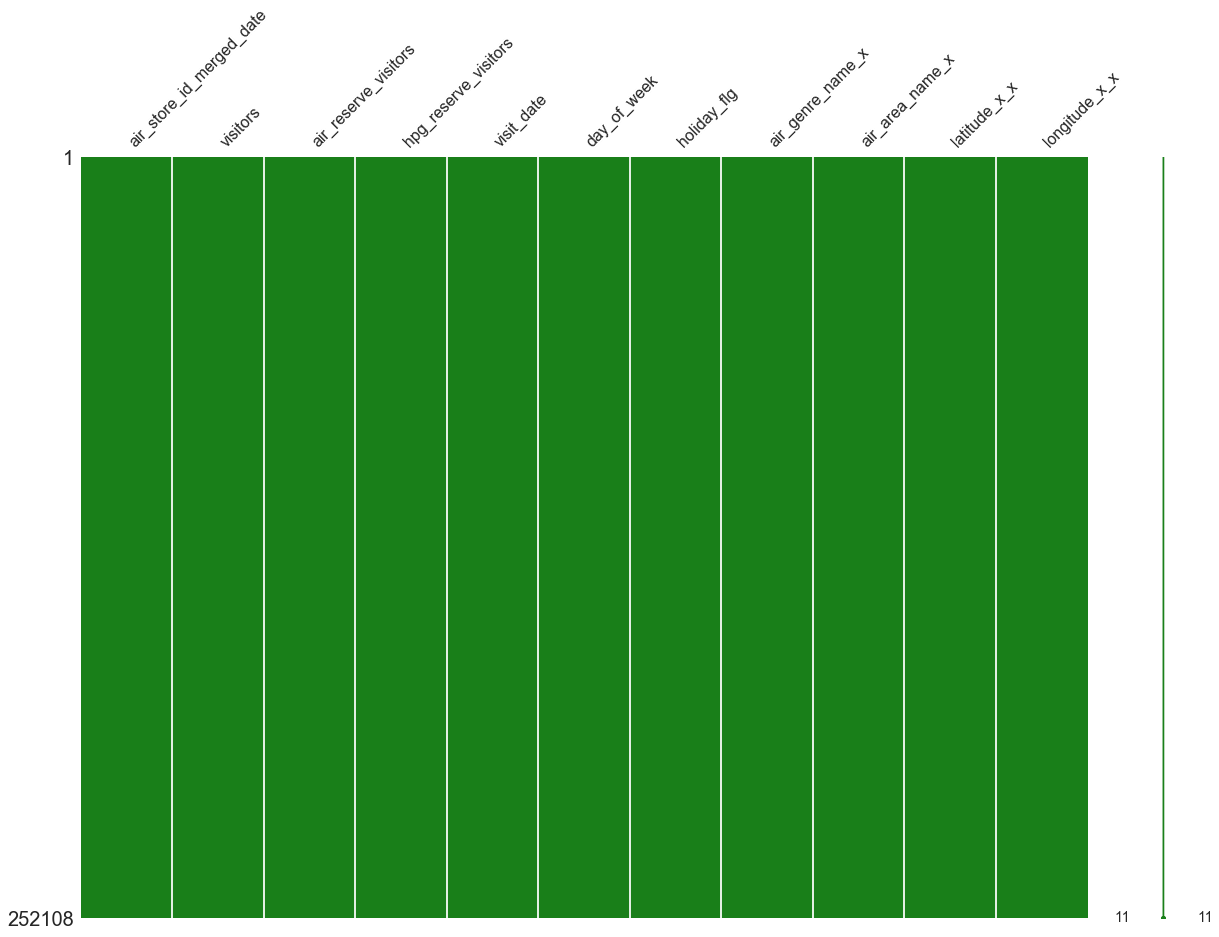

In [425]:
import missingno as msno
msno.matrix(df=train_test, figsize=(20,14), color=(0.1,0.5,0.1))

In [426]:
#CSVへ吐き出す

train_test.to_csv("./train_test.csv", index=False)

## 特徴量作成(昨年データが存在する店舗は予約なし訪問が８割を説明可能）

In [427]:
# to numeric feature
cols = ['air_reserve_visitors', 'hpg_reserve_visitors']
for c in cols:
    train_test[c] = train_test[c].astype(int)


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### non_reserved_visitors

In [428]:
train_test['non_reserved_visitors'] = train_test['visitors'] - (train_test['air_reserve_visitors'] + train_test['hpg_reserve_visitors']) 
train_test['non_reserved_visitors'].describe()

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


count    252108.000000
mean         19.077340
std          16.878613
min       -1615.000000
25%           8.000000
50%          15.000000
75%          27.000000
max         877.000000
Name: non_reserved_visitors, dtype: float64

In [429]:
train_test.sort_values('non_reserved_visitors', ascending=True)

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,non_reserved_visitors
17043,air_e7fbee4e3cfe65c5_2017-02-05,18,1633,0,2017-02-05,Sunday,0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,-1615
17041,air_e7fbee4e3cfe65c5_2017-02-03,33,664,0,2017-02-03,Friday,0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,-631
17042,air_e7fbee4e3cfe65c5_2017-02-04,56,641,0,2017-02-04,Saturday,0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,-585
17044,air_e7fbee4e3cfe65c5_2017-02-07,27,557,0,2017-02-07,Tuesday,0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,-530
68051,air_465bddfed3353b23_2017-01-09,30,466,0,2017-01-09,Monday,1,Dining bar,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,-436
108738,air_a17f0778617c76e2_2017-03-16,17,142,0,2017-03-16,Thursday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,-125
46064,air_db80363d35f10926_2017-03-19,88,54,137,2017-03-19,Sunday,0,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,-103
115859,air_52a08ef3efdb4bb0_2017-04-08,2,0,100,2017-04-08,Saturday,0,Bar/Cocktail,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,-98
8845,air_7514d90009613cd6_2016-12-17,170,107,157,2016-12-17,Saturday,0,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,-94
71565,air_b439391e72899756_2017-02-23,11,104,0,2017-02-23,Thursday,0,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,-93


In [430]:
#外れ値を消します
#train_test_sample = train_test[train_test['non_reserved_visitors'] > -1]
#train_test_sample['non_reserved_visitors'].describe()

### 天気をくっつける

In [431]:
# air_area_name_xのなかで、''より後ろ を消して、都道府県表示を
train_test_a = train_test['air_area_name_x'].str.split(' ', expand=True)
train_test_a = train_test_a[0]
train_test_a.unique()

array(['Tōkyō-to', 'Ōsaka-fu', 'Hokkaidō', 'Shizuoka-ken', 'Fukuoka-ken',
       'Hiroshima-ken', 'Hyōgo-ken', 'Niigata-ken', 'Miyagi-ken'],
      dtype=object)

In [432]:
train_test_weather = pd.concat([train_test, train_test_a], axis=1)
train_test_weather.head()

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,non_reserved_visitors,0
0,air_ba937bf13d40fb24_2016-01-13,25,0,0,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25,Tōkyō-to
1,air_ba937bf13d40fb24_2016-01-14,32,0,0,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32,Tōkyō-to
2,air_ba937bf13d40fb24_2016-01-15,29,0,0,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29,Tōkyō-to
3,air_ba937bf13d40fb24_2016-01-16,22,0,0,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22,Tōkyō-to
4,air_ba937bf13d40fb24_2016-01-18,6,0,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,Tōkyō-to


In [433]:
#Column名を変更
train_test_weather = train_test_weather.rename(columns={0: 'prefecture'})
train_test_weather.head()

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,non_reserved_visitors,prefecture
0,air_ba937bf13d40fb24_2016-01-13,25,0,0,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25,Tōkyō-to
1,air_ba937bf13d40fb24_2016-01-14,32,0,0,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32,Tōkyō-to
2,air_ba937bf13d40fb24_2016-01-15,29,0,0,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29,Tōkyō-to
3,air_ba937bf13d40fb24_2016-01-16,22,0,0,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22,Tōkyō-to
4,air_ba937bf13d40fb24_2016-01-18,6,0,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,Tōkyō-to


In [434]:
#その前に、prefecture_by_dateとvisit_date をくっつけたやつを作っておく
train_test_weather['prefecture_by_date'] = train_test_weather['prefecture'].str.cat(train_test_weather['visit_date'], sep='_')
train_test_weather.head(1000)

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,non_reserved_visitors,prefecture,prefecture_by_date
0,air_ba937bf13d40fb24_2016-01-13,25,0,0,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25,Tōkyō-to,Tōkyō-to_2016-01-13
1,air_ba937bf13d40fb24_2016-01-14,32,0,0,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32,Tōkyō-to,Tōkyō-to_2016-01-14
2,air_ba937bf13d40fb24_2016-01-15,29,0,0,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29,Tōkyō-to,Tōkyō-to_2016-01-15
3,air_ba937bf13d40fb24_2016-01-16,22,0,0,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22,Tōkyō-to,Tōkyō-to_2016-01-16
4,air_ba937bf13d40fb24_2016-01-18,6,0,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,Tōkyō-to,Tōkyō-to_2016-01-18
5,air_ba937bf13d40fb24_2016-01-19,9,0,0,2016-01-19,Tuesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,9,Tōkyō-to,Tōkyō-to_2016-01-19
6,air_ba937bf13d40fb24_2016-01-20,31,0,0,2016-01-20,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,31,Tōkyō-to,Tōkyō-to_2016-01-20
7,air_ba937bf13d40fb24_2016-01-21,21,0,0,2016-01-21,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,21,Tōkyō-to,Tōkyō-to_2016-01-21
8,air_ba937bf13d40fb24_2016-01-22,18,0,0,2016-01-22,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,18,Tōkyō-to,Tōkyō-to_2016-01-22
9,air_ba937bf13d40fb24_2016-01-23,26,0,0,2016-01-23,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,26,Tōkyō-to,Tōkyō-to_2016-01-23


#### 天気を読み込む

In [435]:
weather = pd.read_csv('./weather.csv', encoding="shift-jis")
weather.head()

,Date,Weather,Prefecture
0,2016-01-01,Sunny,T_ky_-to
1,2016-01-02,Sunny,T_ky_-to
2,2016-01-03,Sunny,T_ky_-to
3,2016-01-04,Sunny,T_ky_-to
4,2016-01-05,Sunny,T_ky_-to


In [436]:
weather['Prefecture'].unique()

array(['T_ky_-to', 'Shizuoka-ken', 'Niigata-ken', 'Miyagi-ken',
       'Hy_go-ken', 'Hokkaid_', 'Hiroshima-ken', 'Fukuoka-ken',
       '_saka-fu'], dtype=object)

In [437]:
#　文字列を修正する
weather =weather.replace({'T_ky_-to': 'Tōkyō-to', '_saka-fu': 'Ōsaka-fu', 'Hokkaid_': 'Hokkaidō', 'Hy_go-ken': 'Hyōgo-ken' })
weather.head()

,Date,Weather,Prefecture
0,2016-01-01,Sunny,Tōkyō-to
1,2016-01-02,Sunny,Tōkyō-to
2,2016-01-03,Sunny,Tōkyō-to
3,2016-01-04,Sunny,Tōkyō-to
4,2016-01-05,Sunny,Tōkyō-to


In [438]:
#その前に、air_store_idとvisit_date をくっつけたやつを作っておく
weather['prefecture_by_date'] = weather['Prefecture'].str.cat(weather['Date'], sep='_')
weather.head()


,Date,Weather,Prefecture,prefecture_by_date
0,2016-01-01,Sunny,Tōkyō-to,Tōkyō-to_2016-01-01
1,2016-01-02,Sunny,Tōkyō-to,Tōkyō-to_2016-01-02
2,2016-01-03,Sunny,Tōkyō-to,Tōkyō-to_2016-01-03
3,2016-01-04,Sunny,Tōkyō-to,Tōkyō-to_2016-01-04
4,2016-01-05,Sunny,Tōkyō-to,Tōkyō-to_2016-01-05


In [439]:
weather_prep = weather[['prefecture_by_date', 'Weather']]
weather_prep.head()

,prefecture_by_date,Weather
0,Tōkyō-to_2016-01-01,Sunny
1,Tōkyō-to_2016-01-02,Sunny
2,Tōkyō-to_2016-01-03,Sunny
3,Tōkyō-to_2016-01-04,Sunny
4,Tōkyō-to_2016-01-05,Sunny


## 前処理完了(昨年のデータセットが存在する店の予測のための）

In [440]:
#air_visit_data, date_info
train_test_weather_new = pd.merge(train_test_weather, weather_prep, on='prefecture_by_date', how = 'left')
train_test_weather_new.head()

,air_store_id_merged_date,visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,air_area_name_x,latitude_x_x,longitude_x_x,non_reserved_visitors,prefecture,prefecture_by_date,Weather
0,air_ba937bf13d40fb24_2016-01-13,25,0,0,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,25,Tōkyō-to,Tōkyō-to_2016-01-13,Sunny
1,air_ba937bf13d40fb24_2016-01-14,32,0,0,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,32,Tōkyō-to,Tōkyō-to_2016-01-14,Sunny
2,air_ba937bf13d40fb24_2016-01-15,29,0,0,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,29,Tōkyō-to,Tōkyō-to_2016-01-15,Sunny
3,air_ba937bf13d40fb24_2016-01-16,22,0,0,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22,Tōkyō-to,Tōkyō-to_2016-01-16,Sunny
4,air_ba937bf13d40fb24_2016-01-18,6,0,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,Tōkyō-to,Tōkyō-to_2016-01-18,Rain_Heavy


In [441]:
train_test_weather_new = train_test_weather_new[['air_store_id_merged_date', 'visitors', 'non_reserved_visitors', 'air_reserve_visitors', 'hpg_reserve_visitors', 'visit_date', 'day_of_week', 'holiday_flg', 'air_genre_name_x', 'prefecture', 'Weather' ]]

In [442]:
train_test_weather_new.head(1000)

,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,visit_date,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather
0,air_ba937bf13d40fb24_2016-01-13,25,25,0,0,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to,Sunny
1,air_ba937bf13d40fb24_2016-01-14,32,32,0,0,2016-01-14,Thursday,0,Dining bar,Tōkyō-to,Sunny
2,air_ba937bf13d40fb24_2016-01-15,29,29,0,0,2016-01-15,Friday,0,Dining bar,Tōkyō-to,Sunny
3,air_ba937bf13d40fb24_2016-01-16,22,22,0,0,2016-01-16,Saturday,0,Dining bar,Tōkyō-to,Sunny
4,air_ba937bf13d40fb24_2016-01-18,6,6,0,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to,Rain_Heavy
5,air_ba937bf13d40fb24_2016-01-19,9,9,0,0,2016-01-19,Tuesday,0,Dining bar,Tōkyō-to,Sunny
6,air_ba937bf13d40fb24_2016-01-20,31,31,0,0,2016-01-20,Wednesday,0,Dining bar,Tōkyō-to,Sunny
7,air_ba937bf13d40fb24_2016-01-21,21,21,0,0,2016-01-21,Thursday,0,Dining bar,Tōkyō-to,Cloudy
8,air_ba937bf13d40fb24_2016-01-22,18,18,0,0,2016-01-22,Friday,0,Dining bar,Tōkyō-to,Sunny
9,air_ba937bf13d40fb24_2016-01-23,26,26,0,0,2016-01-23,Saturday,0,Dining bar,Tōkyō-to,Cloudy


In [443]:
train_test_weather_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 11 columns):
air_store_id_merged_date    252108 non-null object
visitors                    252108 non-null int64
non_reserved_visitors       252108 non-null int64
air_reserve_visitors        252108 non-null int64
hpg_reserve_visitors        252108 non-null int64
visit_date                  252108 non-null object
day_of_week                 252108 non-null object
holiday_flg                 252108 non-null int64
air_genre_name_x            252108 non-null object
prefecture                  252108 non-null object
Weather                     252108 non-null object
dtypes: int64(5), object(6)
memory usage: 23.1+ MB


## 型を変更

In [444]:
# to categorical feature
cols = ['air_store_id_merged_date', 'day_of_week', 'air_genre_name_x', 'prefecture', 'Weather' ]
for d in cols:
    train_test_weather_new[d] = train_test_weather_new[d].astype('category')

In [445]:
#to datetime feature
train_test_weather_new['visit_date'] = pd.to_datetime(train_test_weather_new['visit_date'])

In [446]:
train_test_weather_new.set_index('visit_date', inplace=True)

In [447]:
train_test_weather_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252108 entries, 2016-01-13 to 2017-04-22
Data columns (total 10 columns):
air_store_id_merged_date    252108 non-null category
visitors                    252108 non-null int64
non_reserved_visitors       252108 non-null int64
air_reserve_visitors        252108 non-null int64
hpg_reserve_visitors        252108 non-null int64
day_of_week                 252108 non-null category
holiday_flg                 252108 non-null int64
air_genre_name_x            252108 non-null category
prefecture                  252108 non-null category
Weather                     252108 non-null category
dtypes: category(5), int64(5)
memory usage: 15.4 MB


In [448]:
train_test_weather_new.head()

,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather
visit_date,,,,,,,,,,
2016-01-13,air_ba937bf13d40fb24_2016-01-13,25,25,0,0,Wednesday,0,Dining bar,Tōkyō-to,Sunny
2016-01-14,air_ba937bf13d40fb24_2016-01-14,32,32,0,0,Thursday,0,Dining bar,Tōkyō-to,Sunny
2016-01-15,air_ba937bf13d40fb24_2016-01-15,29,29,0,0,Friday,0,Dining bar,Tōkyō-to,Sunny
2016-01-16,air_ba937bf13d40fb24_2016-01-16,22,22,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny
2016-01-18,air_ba937bf13d40fb24_2016-01-18,6,6,0,0,Monday,0,Dining bar,Tōkyō-to,Rain_Heavy


# EDA

以上の前処理と、EDAから以下のことがわかった。

- 予約されたデータを用いて、お店のvisitorを予測するとあったが、そもそも全体の中で予約は10％程度でありvisitor全体を予測するには小さすぎる可能性がある
- 予測すべき対象はGWを中心とした期間であるのに、昨年のその範囲で存在しないが３分の２ほどあり多い（昨年の同じ曜日などが使えない）
- EDAからは、曜日や年、など周期性がある、お店の特性によっても、訪れやすさなどがある。

昨年のデータがある場合は曜日合わせをすれば結構当たる可能性があるが、ない場合は他の特徴量に説明力を求める方針としたい
 


In [449]:
#Last_Period(2016:4/24-5/28) =(2017: 4/23-5/27) 曜日合わせ
train_test_weather_p = train_test_weather_new['2016-04-24':'2016-06-01']
train_test_weather_p.head()

,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather
visit_date,,,,,,,,,,
2016-04-25,air_ba937bf13d40fb24_2016-04-25,29,29,0,0,Monday,0,Dining bar,Tōkyō-to,Cloudy
2016-04-26,air_ba937bf13d40fb24_2016-04-26,19,19,0,0,Tuesday,0,Dining bar,Tōkyō-to,Sunny
2016-04-27,air_ba937bf13d40fb24_2016-04-27,9,9,0,0,Wednesday,0,Dining bar,Tōkyō-to,Cloudy
2016-04-28,air_ba937bf13d40fb24_2016-04-28,26,26,0,0,Thursday,0,Dining bar,Tōkyō-to,Rain
2016-04-30,air_ba937bf13d40fb24_2016-04-30,12,12,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny


In [450]:
#GW
train_test_weather_GW = train_test_weather_new['2016-04-29':'2016-05-08']
train_test_weather_GW.head()

,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather
visit_date,,,,,,,,,,
2016-04-30,air_ba937bf13d40fb24_2016-04-30,12,12,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny
2016-05-02,air_ba937bf13d40fb24_2016-05-02,34,34,0,0,Monday,0,Dining bar,Tōkyō-to,Cloudy
2016-05-06,air_ba937bf13d40fb24_2016-05-06,17,17,0,0,Friday,0,Dining bar,Tōkyō-to,Cloudy
2016-05-07,air_ba937bf13d40fb24_2016-05-07,46,46,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny
2016-04-29,air_25e9888d30b386df_2016-04-29,21,21,0,0,Friday,1,Izakaya,Tōkyō-to,Sunny


In [451]:
train_test_weather_p['date'] = train_test_weather_p.index
train_test_weather_GW['date'] = train_test_weather_GW.index

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Visitorのトレンド：日付順

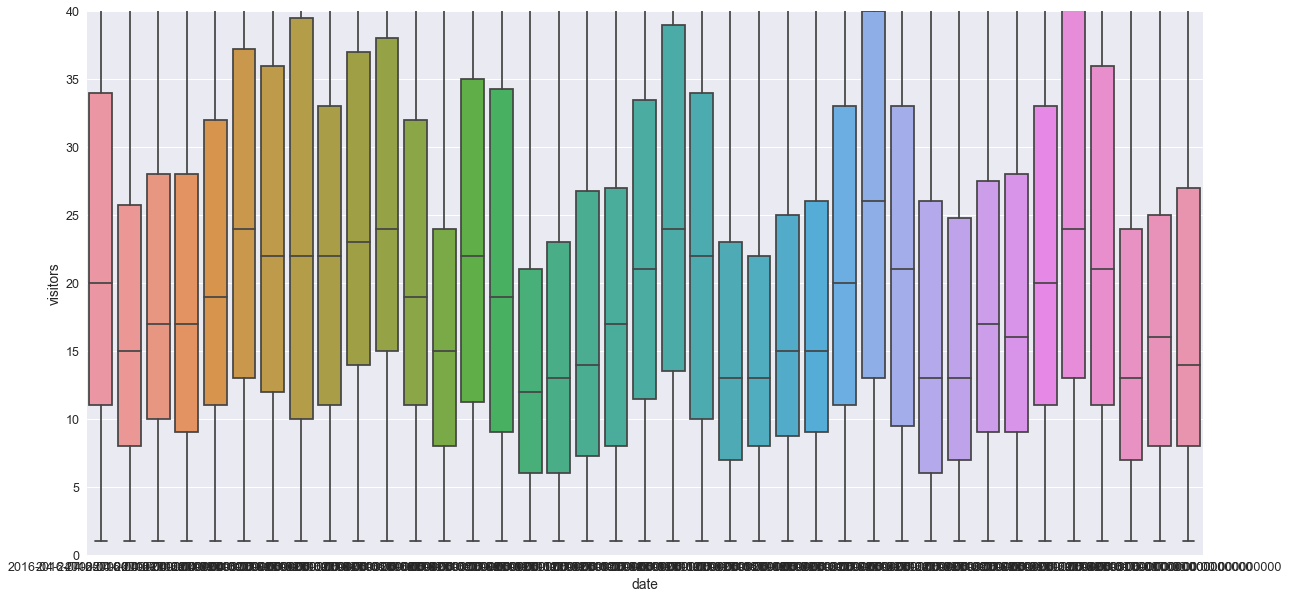

In [452]:
#箱ひげ図：data and visitors
var = 'date'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitorのトレンド：昨年のGWのみ

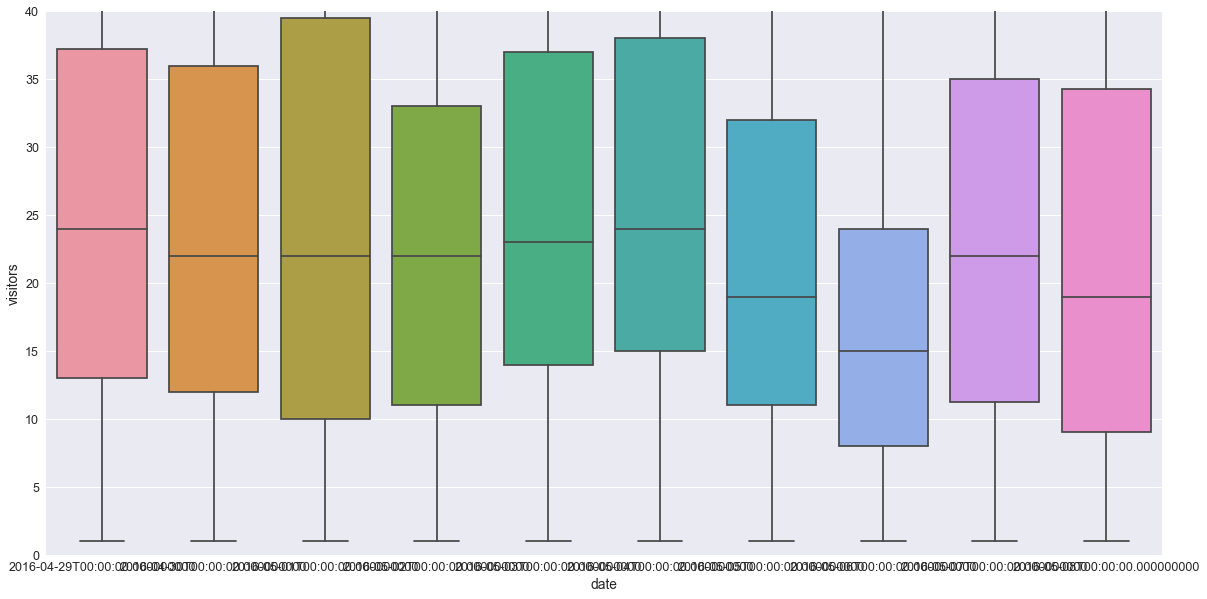

In [453]:
#箱ひげ図：data and visitors
var = 'date'
data = pd.concat([train_test_weather_GW['visitors'], train_test_weather_GW[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitorのトレンド：曜日別

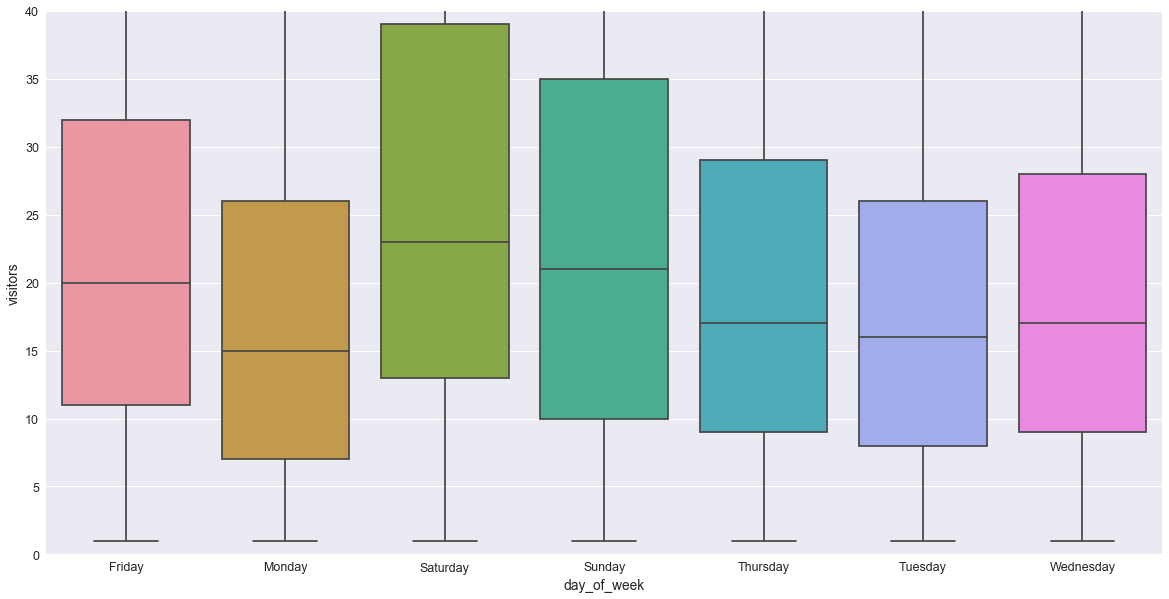

In [454]:
#箱ひげ図： day of week and visitors
var = 'day_of_week'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitorのトレンド：天気別

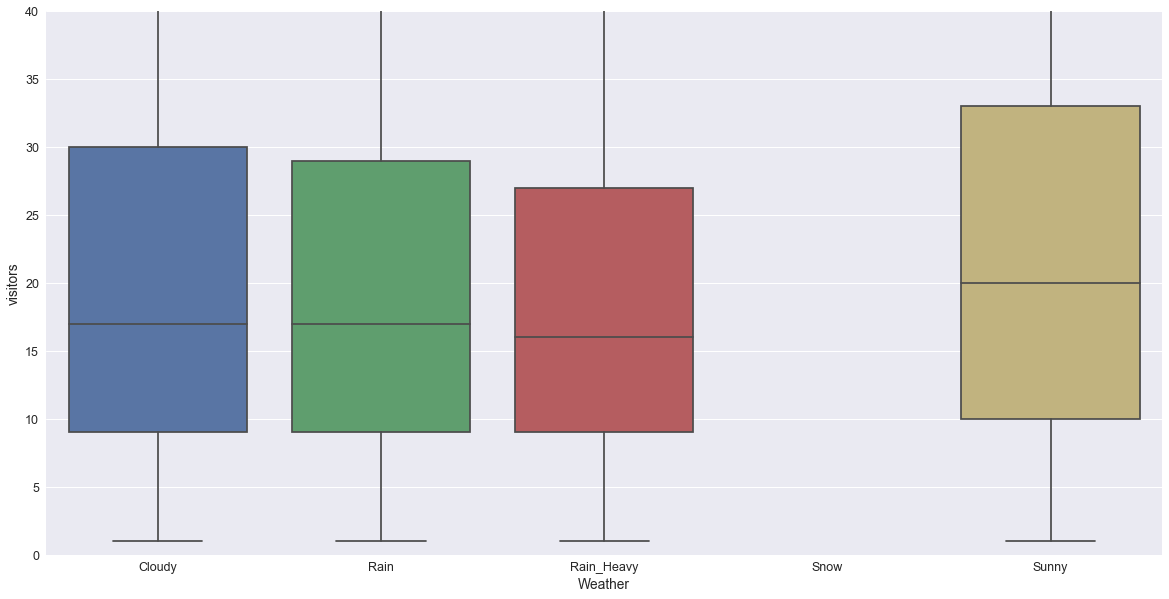

In [455]:
#箱ひげ図： weather
var = 'Weather'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitor：平日（０）と祝日（１）

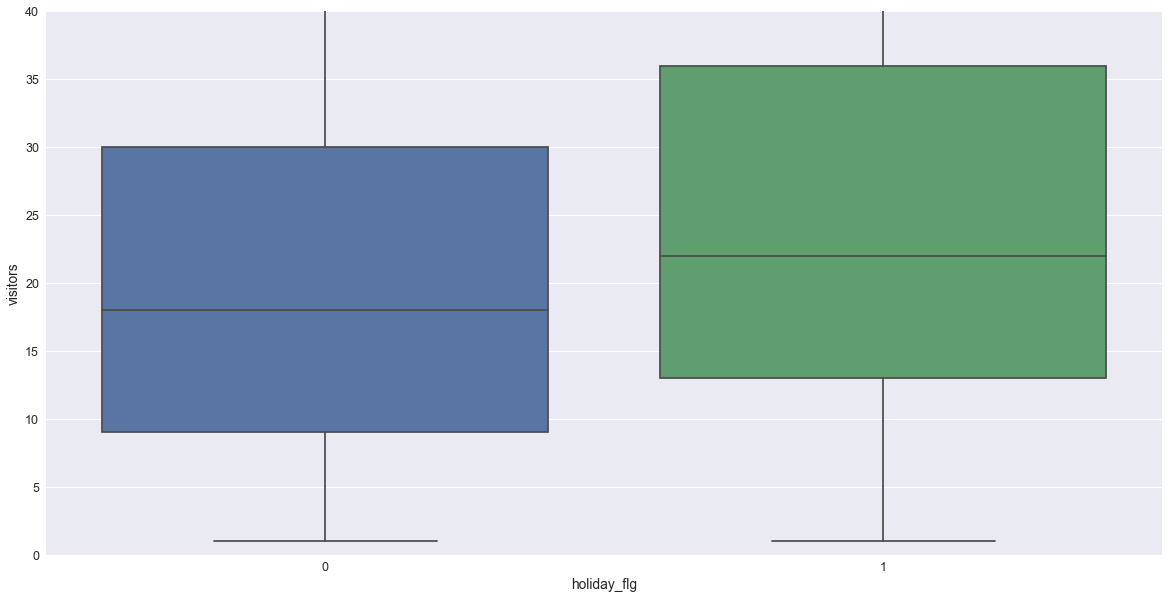

In [456]:
#箱ひげ図： holiday_flg
var = 'holiday_flg'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitor：店のジャンル

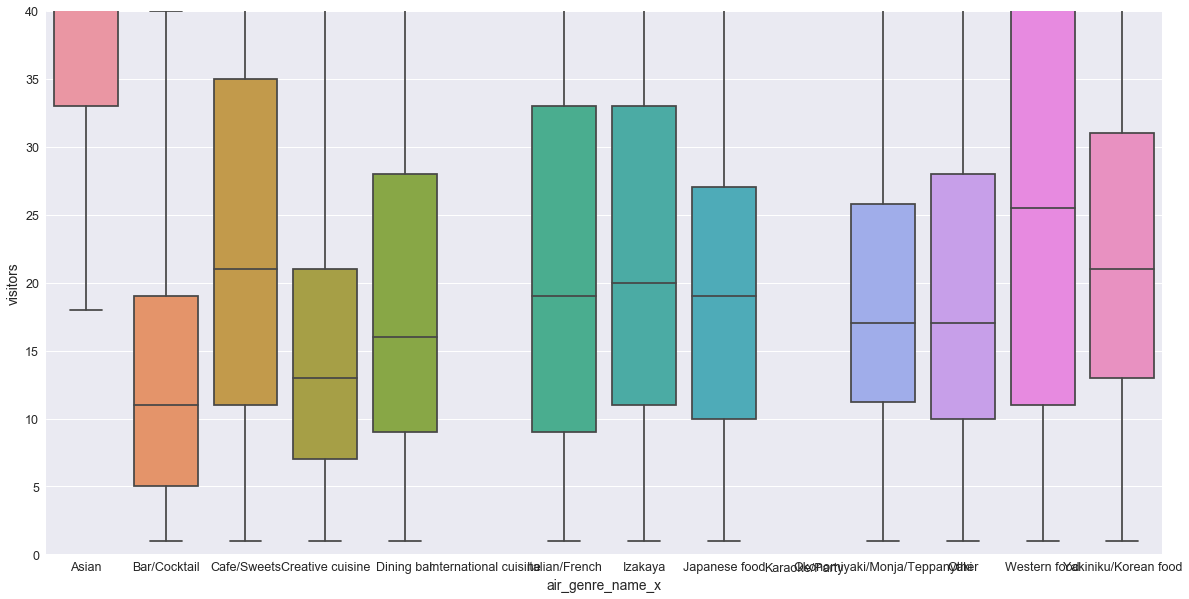

In [457]:

#箱ひげ図： air_genre_name_x
var = 'air_genre_name_x'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

## Visitor：都道府県別

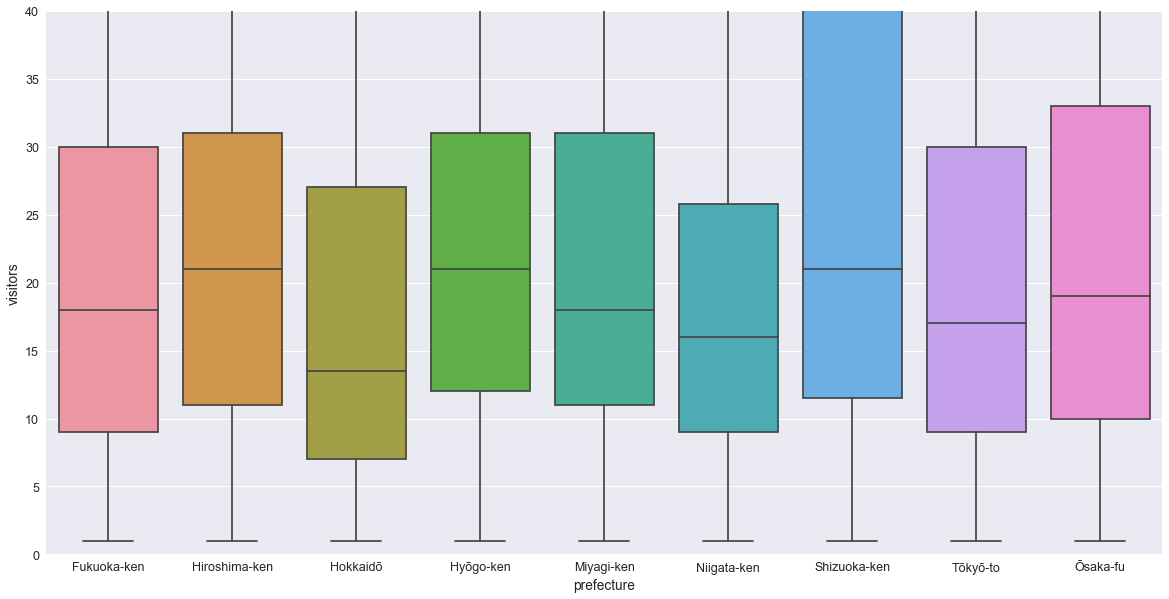

In [458]:
#箱ひげ図： prefecture
var = 'prefecture'
data = pd.concat([train_test_weather_p['visitors'], train_test_weather_p[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="visitors", data=data)
fig.axis(ymin=0, ymax=40);

##   相関行列

In [459]:
corr_matrix = train_test_weather_new.corr()
corr_matrix['visitors']

visitors                 1.000000
non_reserved_visitors    0.887932
air_reserve_visitors     0.206765
hpg_reserve_visitors     0.118853
holiday_flg              0.037634
Name: visitors, dtype: float64

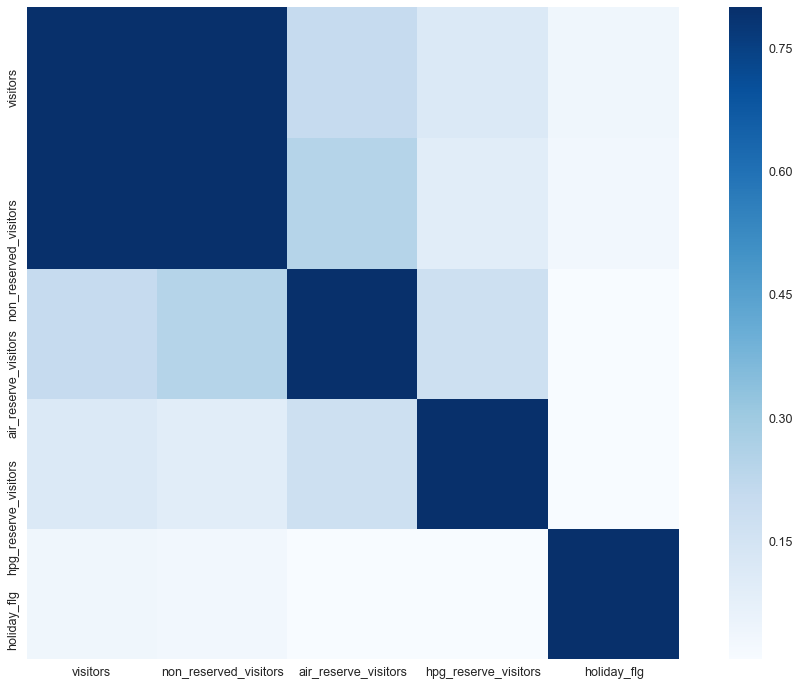

In [460]:
# 相関行列

f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(np.abs(corr_matrix), vmax=.8, cmap='Blues', square=True)

##   予約なしの人数がほとんど（つまり予約なしの人数がわかれば予測はしやすい？）

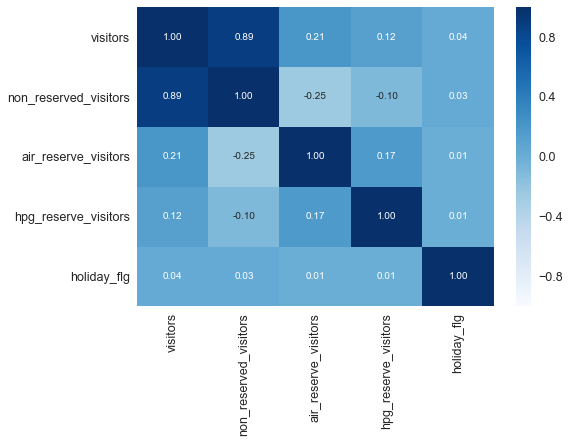

In [461]:
col_check = np.abs(corr_matrix).nlargest(10, 'visitors')['visitors'].index

k =15
# nlargest 大きい順にいくつかとる <->nsmallest 

cols = np.abs(corr_matrix).nlargest(k, 'visitors')['visitors'].index

# 相関係数が大きい順に10こ並べて、そのインデックスをcolsに代入　
cm = np.corrcoef(train_test_weather_new[cols].values.T)

# 項目の名前のフォントを1.25倍する
sns.set(font_scale=1.25) 

hm = sns.heatmap(cm, cbar=True, annot=True, square=False, fmt='.2f', cmap='Blues', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


In [462]:
#CSVへ吐き出す
train_test_weather_new.to_csv("./train_test_weather_new.csv", index=True)
train_test_weather_p.to_csv("./train_test_weather_p.csv", index=True)
train_test_weather_GW.to_csv("./train_test_weather_GW.csv", index=True)

# 予測：昨年店が存在した場合

In [463]:
train_test_weather_new = pd.read_csv('./train_test_weather_new_updated.csv', encoding="SHIFT-JIS")
train_test_weather_new.head()


,visit_date,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id,yoy_date
0,2016-01-13,air_ba937bf13d40fb24_2016-01-13,25,25,0,0,Wednesday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-11
1,2016-01-14,air_ba937bf13d40fb24_2016-01-14,32,32,0,0,Thursday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-12
2,2016-01-15,air_ba937bf13d40fb24_2016-01-15,29,29,0,0,Friday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-13
3,2016-01-16,air_ba937bf13d40fb24_2016-01-16,22,22,0,0,Saturday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-14
4,2016-01-18,air_ba937bf13d40fb24_2016-01-18,6,6,0,0,Monday,0,Dining bar,Tﾅ耕yﾅ-to,Rain_Heavy,air_ba937bf13d40fb24,2017-01-16


In [464]:
## 予測に使う未来日付のair_store_id_merged_dateを用意する
train_test_weather_new['air_store_id_merged_date_new'] = train_test_weather_new['air_store_id'].str.cat(train_test_weather_new['yoy_date'], sep='_')
train_test_weather_new.head()

,visit_date,air_store_id_merged_date,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id,yoy_date,air_store_id_merged_date_new
0,2016-01-13,air_ba937bf13d40fb24_2016-01-13,25,25,0,0,Wednesday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-11,air_ba937bf13d40fb24_2017-01-11
1,2016-01-14,air_ba937bf13d40fb24_2016-01-14,32,32,0,0,Thursday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-12,air_ba937bf13d40fb24_2017-01-12
2,2016-01-15,air_ba937bf13d40fb24_2016-01-15,29,29,0,0,Friday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-13,air_ba937bf13d40fb24_2017-01-13
3,2016-01-16,air_ba937bf13d40fb24_2016-01-16,22,22,0,0,Saturday,0,Dining bar,Tﾅ耕yﾅ-to,Sunny,air_ba937bf13d40fb24,2017-01-14,air_ba937bf13d40fb24_2017-01-14
4,2016-01-18,air_ba937bf13d40fb24_2016-01-18,6,6,0,0,Monday,0,Dining bar,Tﾅ耕yﾅ-to,Rain_Heavy,air_ba937bf13d40fb24,2017-01-16,air_ba937bf13d40fb24_2017-01-16


In [465]:
#prefecture 文字化け取得
train_test_weather_new['prefecture'].unique()


array(['Tﾅ耕yﾅ-to', 'ﾅ茎aka-fu', 'Hokkaidﾅ', 'Shizuoka-ken', 'Fukuoka-ken',
       'Hiroshima-ken', 'Hyﾅ紅o-ken', 'Niigata-ken', 'Miyagi-ken'],
      dtype=object)

In [466]:
#　文字列を修正する
train_test_weather_new['prefecture'] =train_test_weather_new['prefecture'].replace({'Tﾅ耕yﾅ-to': 'Tōkyō-to', 'ﾅ茎aka-fu': 'Ōsaka-fu', 'Hokkaidﾅ': 'Hokkaidō', 'Hyﾅ紅o-ken': 'Hyōgo-ken' })
train_test_weather_new['prefecture'].unique()

array(['Tōkyō-to', 'Ōsaka-fu', 'Hokkaidō', 'Shizuoka-ken', 'Fukuoka-ken',
       'Hiroshima-ken', 'Hyōgo-ken', 'Niigata-ken', 'Miyagi-ken'],
      dtype=object)

## 評価関数の作成

ここでは、以下の関数で評価をする。

RMSLE - Root Mean Squared Log Error . 

This metric is used when the Target variable is converted into Log(Target). 
so instead of looking at RMSLE, you can look for RMSE (generally we use this). 


In [467]:
#評価関数を用意する
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

In [468]:
# 評価関数を定義
def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)

### なぜこの関数を使うか

予測した来客数と、実際の来客数の差を評価（誤差関数）する。
数ある誤差関数の中でlog(x+1)の値を取った理由としては、誤差のスケールを合わせるという理由がある。

例で示す。

下の図のように、予測値20人と実際の来客者10人のときの誤差と予測値50人と実際の来客者60人のときの誤差は前者の方が大きい。

店側の損失としてもたくさん来たときはお断りすればよいだけなので損失は少ないが、 人数が少ないときは材料費もたくさん買うときよりも高くつくため、予測が外れたときの損失は大きい。


今回のコンペではこのような店側の損失を考慮し、対数を取った誤差を採用していると考えられる

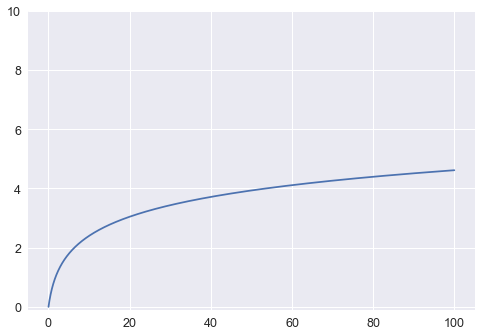

In [469]:
x = np.arange(.0,100,0.01)
y = np.log(x + 1)

plt.ylim(-0.1, 10)

plt.plot(x,y)
plt.show()

## データセットの確認

In [470]:
#
train_test_new = train_test_weather_new[['air_store_id_merged_date_new', 'visitors', 'non_reserved_visitors', 'air_reserve_visitors', 'hpg_reserve_visitors', 'day_of_week', 'holiday_flg', 'air_genre_name_x', 'prefecture', 'Weather', 'air_store_id']]
train_test_new.head()

,air_store_id_merged_date_new,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id
0,air_ba937bf13d40fb24_2017-01-11,25,25,0,0,Wednesday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2017-01-12,32,32,0,0,Thursday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2017-01-13,29,29,0,0,Friday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2017-01-14,22,22,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2017-01-16,6,6,0,0,Monday,0,Dining bar,Tōkyō-to,Rain_Heavy,air_ba937bf13d40fb24


## 分割

In [471]:
#GBMに打ち込むので、dtypeを確認（必要あれば、数値とCategory、float64からfloat32型へ等へ）
train_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 11 columns):
air_store_id_merged_date_new    252108 non-null object
visitors                        252108 non-null int64
non_reserved_visitors           252108 non-null int64
air_reserve_visitors            252108 non-null int64
hpg_reserve_visitors            252108 non-null int64
day_of_week                     252108 non-null object
holiday_flg                     252108 non-null int64
air_genre_name_x                252108 non-null object
prefecture                      252108 non-null object
Weather                         252108 non-null object
air_store_id                    252108 non-null object
dtypes: int64(5), object(6)
memory usage: 21.2+ MB


In [472]:
#GBMに打ち込むので、dtypeを確認（必要あれば、数値とCategory、float64からfloat32型へ等へ）
# for c, dtype in zip(train.columns, train.dtypes):
#     if dtype == np.float64:
#         train[c] = train[c].astype(np.float32)

# for c, dtype in zip(test.columns, test.dtypes):
#     if dtype == np.float64:
#         test[c] = test[c].astype(np.float32)

# to categorical feature
cols = ['air_store_id_merged_date_new', 'day_of_week', 'air_genre_name_x', 'prefecture', 'Weather', 'air_store_id' ]
for d in cols:
    train_test_new[d] = train_test_new[d].astype('category')

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [473]:
train_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 11 columns):
air_store_id_merged_date_new    252108 non-null category
visitors                        252108 non-null int64
non_reserved_visitors           252108 non-null int64
air_reserve_visitors            252108 non-null int64
hpg_reserve_visitors            252108 non-null int64
day_of_week                     252108 non-null category
holiday_flg                     252108 non-null int64
air_genre_name_x                252108 non-null category
prefecture                      252108 non-null category
Weather                         252108 non-null category
air_store_id                    252108 non-null category
dtypes: category(6), int64(5)
memory usage: 14.0 MB


## Train とTestで分ける（特にSample Submissionに入っているデータはTestへ）

In [474]:
store_id_for_submission = pd.read_csv('./store_id_for_submission.csv')
store_id_for_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 1 columns):
air_store_id_merged_date_new    32019 non-null object
dtypes: object(1)
memory usage: 250.2+ KB


In [475]:
test = pd.merge(train_test_new, store_id_for_submission, on='air_store_id_merged_date_new', how='right')
test.head(-1000)

,air_store_id_merged_date_new,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id
0,air_ba937bf13d40fb24_2017-04-24,29.0,29.0,0.0,0.0,Monday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2017-04-25,19.0,19.0,0.0,0.0,Tuesday,0.0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2017-04-26,9.0,9.0,0.0,0.0,Wednesday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2017-04-27,26.0,26.0,0.0,0.0,Thursday,0.0,Dining bar,Tōkyō-to,Rain,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2017-04-29,12.0,12.0,0.0,0.0,Saturday,0.0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
5,air_ba937bf13d40fb24_2017-05-01,34.0,34.0,0.0,0.0,Monday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
6,air_ba937bf13d40fb24_2017-05-05,17.0,17.0,0.0,0.0,Friday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
7,air_ba937bf13d40fb24_2017-05-06,46.0,46.0,0.0,0.0,Saturday,0.0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
8,air_ba937bf13d40fb24_2017-05-08,12.0,12.0,0.0,0.0,Monday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
9,air_ba937bf13d40fb24_2017-05-09,14.0,14.0,0.0,0.0,Tuesday,0.0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24


In [476]:
test.shape

(32019, 11)

In [477]:
# to categorical feature
cols = ['day_of_week', 'air_genre_name_x', 'prefecture', 'Weather', 'air_store_id' ]
for d in cols:
    test[d] = test[d].astype('category')

In [478]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 11 columns):
air_store_id_merged_date_new    10240 non-null category
visitors                        10240 non-null float64
non_reserved_visitors           10240 non-null float64
air_reserve_visitors            10240 non-null float64
hpg_reserve_visitors            10240 non-null float64
day_of_week                     10240 non-null category
holiday_flg                     10240 non-null float64
air_genre_name_x                10240 non-null category
prefecture                      10240 non-null category
Weather                         10240 non-null category
air_store_id                    10240 non-null category
dtypes: category(6), float64(5)
memory usage: 3.7 MB


In [479]:
# fillna
for f in ['visitors', 'non_reserved_visitors', 'air_reserve_visitors', 'hpg_reserve_visitors', 'holiday_flg']:
    test[f].fillna('0', inplace=True)

In [480]:
# to numeric feature
cols = ['visitors', 'non_reserved_visitors', 'air_reserve_visitors', 'hpg_reserve_visitors', 'holiday_flg']
for e in cols:
    test[e] = test[e].astype(int)

In [481]:
train = train_test_new[~train_test_new['air_store_id_merged_date_new'].isin(store_id_for_submission['air_store_id_merged_date_new'])]

In [482]:
train.head()

,air_store_id_merged_date_new,visitors,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id
0,air_ba937bf13d40fb24_2017-01-11,25,25,0,0,Wednesday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2017-01-12,32,32,0,0,Thursday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2017-01-13,29,29,0,0,Friday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2017-01-14,22,22,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2017-01-16,6,6,0,0,Monday,0,Dining bar,Tōkyō-to,Rain_Heavy,air_ba937bf13d40fb24


In [483]:
X_train = train.drop(['visitors'], axis=1)
y_train = train['visitors']
X_test = test.drop(['visitors'], axis=1)
y_test = test['visitors']

In [484]:
# # 説明変数を作成、　特徴量として店のIDと訪問日、来客者数（目的変数）を省く
# X = train_test_new.drop(['visitors'], axis=1)
# # 目的変数を格納
# y = train_test_new['visitors']

# # テストデータの説明変数を作成
# #X_test = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)


In [485]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241868 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id_merged_date_new    241868 non-null category
non_reserved_visitors           241868 non-null int64
air_reserve_visitors            241868 non-null int64
hpg_reserve_visitors            241868 non-null int64
day_of_week                     241868 non-null category
holiday_flg                     241868 non-null int64
air_genre_name_x                241868 non-null category
prefecture                      241868 non-null category
Weather                         241868 non-null category
air_store_id                    241868 non-null category
dtypes: category(6), int64(4)
memory usage: 13.5 MB


In [486]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 10 columns):
air_store_id_merged_date_new    10240 non-null category
non_reserved_visitors           32019 non-null int64
air_reserve_visitors            32019 non-null int64
hpg_reserve_visitors            32019 non-null int64
day_of_week                     10240 non-null category
holiday_flg                     32019 non-null int64
air_genre_name_x                10240 non-null category
prefecture                      10240 non-null category
Weather                         10240 non-null category
air_store_id                    10240 non-null category
dtypes: category(6), int64(4)
memory usage: 3.5 MB


In [487]:
#GBMに打ち込むので、dtypeを確認（必要あれば、数値とCategory、float64からfloat32型へ等へ）
# for c, dtype in zip(train.columns, train.dtypes):
#     if dtype == np.float64:
#         train[c] = train[c].astype(np.float32)

# for c, dtype in zip(test.columns, test.dtypes):
#     if dtype == np.float64:
#         test[c] = test[c].astype(np.float32)



In [488]:
# # trainとtestにまず分ける
# #testは今回与えられているSubmissionファイルのair_store_idとする。

# from sklearn.model_selection import train_test_split

# X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [489]:
X_test.head()

,air_store_id_merged_date_new,non_reserved_visitors,air_reserve_visitors,hpg_reserve_visitors,day_of_week,holiday_flg,air_genre_name_x,prefecture,Weather,air_store_id
0,air_ba937bf13d40fb24_2017-04-24,29,0,0,Monday,0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
1,air_ba937bf13d40fb24_2017-04-25,19,0,0,Tuesday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24
2,air_ba937bf13d40fb24_2017-04-26,9,0,0,Wednesday,0,Dining bar,Tōkyō-to,Cloudy,air_ba937bf13d40fb24
3,air_ba937bf13d40fb24_2017-04-27,26,0,0,Thursday,0,Dining bar,Tōkyō-to,Rain,air_ba937bf13d40fb24
4,air_ba937bf13d40fb24_2017-04-29,12,0,0,Saturday,0,Dining bar,Tōkyō-to,Sunny,air_ba937bf13d40fb24


In [490]:
print("X_train : {}".format(X_train.shape))
print("X_test : {}".format(X_test.shape))
print("y_train : {}".format(y_train.shape))
print("y_test : {}".format(y_test.shape))


X_train : (241868, 10)
X_test : (32019, 10)
y_train : (241868,)
y_test : (32019,)


## 学習

In [491]:
# parameter tuning of lightgbm
# start at default setting
import lightgbm as lgb
regg = lgb.LGBMRegressor(
    objective='regression', # 回帰
    num_leaves=60, 
    learning_rate=0.01,
    n_estimators=10000)

# trainさせる
regg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=60, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

### 仮RMSLEを求める

In [492]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from math import sqrt

y_predict = regg.predict(X_test)
# 0以下の値は0に変換する
y_predict[y_predict<0] = 0

rmsle = np.sqrt(mean_squared_log_error(y_test, y_predict))
print(rmsle)

0.33707762943784403


### パラーメータをUpdateして、再学習
ハイパーパラメータは、本ドキュメントの下の方にある、Bayesian Hyper Parameterを参照

In [493]:
regg = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.01, max_depth=10, min_child_samples=20,
       min_child_weight=12, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
       subsample_for_bin=200000, subsample_freq=0)

# trainさせて、そのままrmsleを用いる
regg.fit(X_train, y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.01, max_depth=10, min_child_samples=20,
       min_child_weight=12, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
       subsample_for_bin=200000, subsample_freq=0)

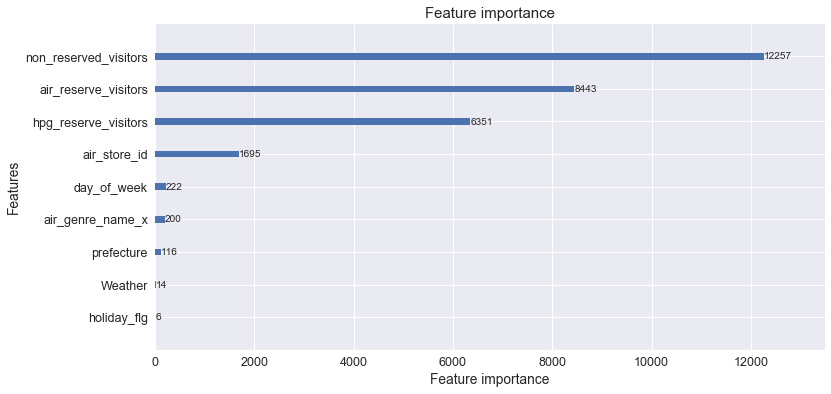

In [563]:
lgb.plot_importance(regg, figsize=(12, 6))
plt.show()

### 予測してRMSLEで評価

In [494]:
y_predict = regg.predict(X_test)
# 0以下の値は0に変換する
y_predict[y_predict<0] = 0

rmsle = np.sqrt(mean_squared_log_error(y_test, y_predict))
print(rmsle)

0.4173323311836329


In [495]:
submission_file = pd.DataFrame({"id": X_test["air_store_id_merged_date_new"], "visitors": y_predict})
submission_file

,id,visitors
0,air_ba937bf13d40fb24_2017-04-24,28.951076
1,air_ba937bf13d40fb24_2017-04-25,18.988929
2,air_ba937bf13d40fb24_2017-04-26,8.974187
3,air_ba937bf13d40fb24_2017-04-27,26.010286
4,air_ba937bf13d40fb24_2017-04-29,12.024744
5,air_ba937bf13d40fb24_2017-05-01,34.004239
6,air_ba937bf13d40fb24_2017-05-05,16.968784
7,air_ba937bf13d40fb24_2017-05-06,46.006287
8,air_ba937bf13d40fb24_2017-05-08,12.024744
9,air_ba937bf13d40fb24_2017-05-09,14.007093


In [496]:
#CSVへ吐き出す
submission_file.to_csv('submission_file1.csv', index=False)

## 注意：submission_file1
このデータでもわかるように、下3分の２ほどのデータセットのIDが出てこない。
これは、昨年の区間でこの店のIDが存在しなかったことによる。


したがって、ここからは、下3分の２のデータセットを予測できるように持って行く。

尚、最初からデータセットを分割すると、比較が難しいため、また新規に全てのデータを読んで、必要特徴量にして行く。

# 前処理２：昨年店が存在しない場合

## 違う名称で入れMergeして行く

In [497]:
ar = pd.read_csv('./air_reserve.csv')
asi = pd.read_csv('./air_store_info.csv')
tra = pd.read_csv('./air_visit_data.csv')
hol = pd.read_csv('./date_info.csv').rename(columns={'calendar_date': 'visit_date'})
hr = pd.read_csv('./hpg_reserve.csv')
hs = pd.read_csv('./hpg_store_info.csv')
tes = pd.read_csv('./sample_submission.csv')
id = pd.read_csv('./store_id_relation.csv')

### HPGに内部結合

In [498]:
hr = pd.merge(hr, id, how='inner', on='hpg_store_id')

### airとhpgの予約情報

In [499]:
for df in [ar, hr]:
    # datetime型に変換
    df['visit_datetime'] = pd.to_datetime(df['visit_datetime'])
    df['visit_datetime'] = df['visit_datetime'].dt.date.astype('datetime64')
    df['reserve_datetime'] = pd.to_datetime(df['reserve_datetime'])
    df['reserve_datetime'] = df['reserve_datetime'].dt.date.astype('datetime64')
    

### 予約日と訪問日の差をreserve_date_diffに格納

In [500]:
for df in [ar, hr]:
    df['reserve_datetime_diff'] = df.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    df = df.groupby(['air_store_id', 'visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime': 'visit_date'})      

In [501]:
ar.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_datetime_diff
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,0
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,0
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,0
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,0


In [502]:
#名前だけ変更
ar = ar.rename(columns={'visit_datetime': 'visit_date', 'reserve_datetime': 'reserve_date'})
hr = hr.rename(columns={'visit_datetime': 'visit_date', 'reserve_datetime': 'reserve_date'})

### 訓練データに特徴量として、年月日、曜日、年、月を追加

In [503]:
tra['visit_date'] = pd.to_datetime(tra['visit_date'])
tra['dow'] = tra['visit_date'].dt.dayofweek
tra['year'] = tra['visit_date'].dt.year
tra['month'] = tra['visit_date'].dt.month
tra['visit_date'] = tra['visit_date'].dt.date

In [504]:
tra.head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


### テストデータのidをair_store_idとvisit_dateに分割

In [505]:
tes['visit_date'] = tes['id'].map(lambda x: str(x).split('_')[2])
tes['air_store_id'] = tes['id'].map(lambda x: '_'.join(x.split('_')[:2]))

### テストデータに特徴量として、年月日、曜日、年、月を追加

In [506]:
tes['visit_date'] = pd.to_datetime(tes['visit_date'])
tes['dow'] = tes['visit_date'].dt.dayofweek
tes['year'] = tes['visit_date'].dt.year
tes['month'] = tes['visit_date'].dt.month
tes['visit_date'] = tes['visit_date'].dt.date

### 予測しなければならない店のair_idを保持

In [507]:
unique_stores = tes['air_store_id'].unique()
unique_stores

array(['air_00a91d42b08b08d9', 'air_0164b9927d20bcc3',
       'air_0241aa3964b7f861', 'air_0328696196e46f18',
       'air_034a3d5b40d5b1b1', 'air_036d4f1ee7285390',
       'air_0382c794b73b51ad', 'air_03963426c9312048',
       'air_04341b588bde96cd', 'air_049f6d5b402a31b2',
       'air_04cae7c1bc9b2a0b', 'air_0585011fa179bcce',
       'air_05c325d315cc17f5', 'air_0647f17b4dc041c8',
       'air_064e203265ee5753', 'air_066f0221b8a4d533',
       'air_06f95ac5c33aca10', 'air_0728814bd98f7367',
       'air_0768ab3910f7967f', 'air_07b314d83059c4d2',
       'air_07bb665f9cdfbdfb', 'air_082908692355165e',
       'air_083ddc520ea47e1e', 'air_0845d8395f30c6bb',
       'air_084d98859256acf0', 'air_0867f7bebad6a649',
       'air_08ba8cd01b3ba010', 'air_08cb3c4ee6cd6a22',
       'air_08ef81d5b7a0d13f', 'air_08f994758a1e76d4',
       'air_09040f6df960ddb8', 'air_0919d54f0c9a24b8',
       'air_09661c0f3259cc04', 'air_09a845d5b5944b01',
       'air_09fd1f5c58583141', 'air_0a74a5408a0b8642',
       'ai

### 店ごとに７日分の行を確保

In [508]:
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i] * len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

### 最少値, 平均, 中央値, 最大値

In [509]:
tmp = tra.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].min().rename(columns={'visitors': 'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = tra.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].mean().rename(columns={'visitors': 'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = tra.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].median().rename(columns={'visitors': 'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = tra.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].max().rename(columns={'visitors': 'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = tra.groupby(['air_store_id', 'dow'], as_index=False)['visitors'].count().rename(columns={'visitors': 'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

### 店のジャンルや位置情報をとり、ラベルエンコードする

In [510]:
stores = pd.merge(stores, asi, how='left', on=['air_store_id'])
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])
stores

,air_store_id,dow,min_visitors_x,min_visitors_y,min_visitors_x,min_visitors_y,min_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229
5,air_036d4f1ee7285390,0,4.0,19.600000,19.0,38.0,40.0,2,31,34.799767,135.360073
6,air_0382c794b73b51ad,0,1.0,20.795455,21.0,47.0,44.0,2,68,35.602125,139.671958
7,air_03963426c9312048,0,2.0,26.030303,26.0,70.0,66.0,7,15,34.386245,132.455018
8,air_04341b588bde96cd,0,5.0,35.417910,33.0,76.0,67.0,7,66,35.735623,139.651658
9,air_049f6d5b402a31b2,0,2.0,9.027778,9.0,20.0,36.0,8,0,33.589216,130.392813


### 祝日や曜日情報（離散値に変換）をtrain、testに結合する

In [511]:
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol['day_of_week'] = lbl.fit_transform(hol['day_of_week'])
hol['visit_date'] = hol['visit_date'].dt.date

train = pd.merge(tra, hol, how='left', on=['visit_date'])
test = pd.merge(tes, hol, how='left', on=['visit_date'])

### storesを結合, 曜日の来客数の最少、平均、中央値、最大値, ジャンルや位置情報も

In [512]:
train = pd.merge(tra, stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(tes, stores, how='left', on=['air_store_id', 'dow'])

### 予約情報を結合

In [513]:
for df in [ar, hr]:
    train = pd.merge(train, df, how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(test, df, how='left', on=['air_store_id', 'visit_date'])

### id, air_store_id, visit_date, visitors以外の項目をcolに格納

In [514]:
col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]

In [515]:
# 欠損値を-1埋めする
train = train.fillna(-1)
test = test.fillna(-1)

In [516]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 22 columns):
air_store_id               252108 non-null object
visit_date                 252108 non-null object
visitors                   252108 non-null int64
dow                        252108 non-null int64
year                       252108 non-null int64
month                      252108 non-null int64
min_visitors_x             252108 non-null float64
min_visitors_y             252108 non-null float64
min_visitors_x             252108 non-null float64
min_visitors_y             252108 non-null float64
min_visitors               252108 non-null float64
air_genre_name             252108 non-null float64
air_area_name              252108 non-null float64
latitude                   252108 non-null float64
longitude                  252108 non-null float64
reserve_date_x             252108 non-null datetime64[ns]
reserve_visitors_x         252108 non-null float64
reserve_datetime_diff_x  

## 評価関数の作成

In [517]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# 評価関数を定義
def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [518]:
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

In [519]:
# float64からfloat32型への変換
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

In [520]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 22 columns):
air_store_id               252108 non-null object
visit_date                 252108 non-null object
visitors                   252108 non-null int64
dow                        252108 non-null int64
year                       252108 non-null int64
month                      252108 non-null int64
min_visitors_x             252108 non-null float32
min_visitors_y             252108 non-null float32
min_visitors_x             252108 non-null float32
min_visitors_y             252108 non-null float32
min_visitors               252108 non-null float32
air_genre_name             252108 non-null float32
air_area_name              252108 non-null float32
latitude                   252108 non-null float32
longitude                  252108 non-null float32
reserve_date_x             252108 non-null datetime64[ns]
reserve_visitors_x         252108 non-null float32
reserve_datetime_diff_x  

## 学習

In [521]:
# to categorical feature
cols = ['reserve_date_x', 'reserve_date_y' ]
for d in cols:
    train[d] = train[d].astype('category')

In [522]:
# to categorical feature
cols = ['reserve_date_x', 'reserve_date_y' ]
for d in cols:
    test[d] = test[d].astype('category')

In [523]:
# 説明変数を作成、　特徴量として店のIDと訪問日、来客者数（目的変数）を省く
X_train = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
# 目的変数を格納
y_train = train['visitors'].values

# テストデータの説明変数を作成
X_test = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)
# 目的変数を格納
y_test = test['visitors'].values

In [524]:
# start from default setting
gbm0 = lgb.LGBMRegressor(
    objective='regression', #
    num_leaves=60, 
    learning_rate=0.01,
    n_estimators=10000)

gbm0.fit(X_train, y_train)



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=60, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

## 再学習
ここでのハイパーパラメータは、ドキュメントの下の方にあるBayesian Hyperparameter を参照

In [525]:
# changed at the best parameter
gbm0 = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.01, max_depth=10, min_child_samples=20,
       min_child_weight=12, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
       subsample_for_bin=200000, subsample_freq=0)

gbm0.fit(X_train, y_train, eval_metric=rmsle)
y_predict = gbm0.predict(X_test)
# 0以下の値は0に変換する
y_predict[y_predict<0] = 0

test['visitors'] = y_predict
test[['id', 'visitors']].to_csv(
    'submission_file2.csv', index=False, float_format='%.3f')

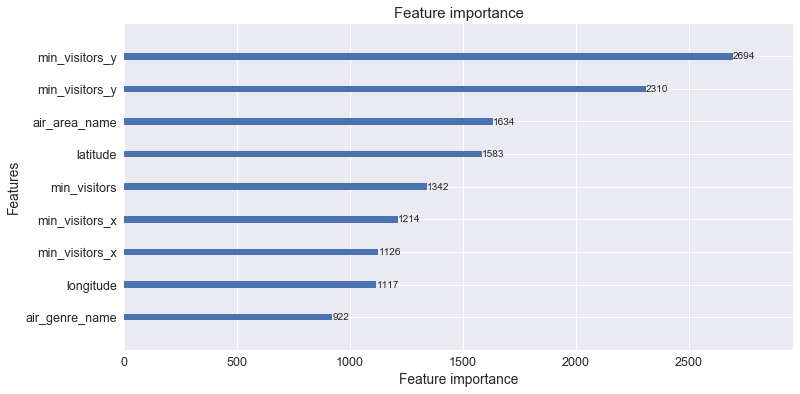

In [562]:
lgb.plot_importance(gbm0, figsize=(12, 6))
plt.show()

## 注意：submission_file2
ここで出たCSVのうち、3分の１を除いて、もともとsubmission_file1と合体させてKaggleのコンペに提出。


0.556の結果


In [549]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline 

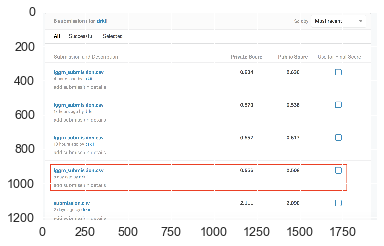

In [558]:
img = Image.open('./Submission.png', 'r')
#type(img)
# リサイズ。サイズは幅と高さをtupleで指定
resize_img = img.resize((1000, 1000))

# リサイズ後の画像を保存
#resize_img.save('Submission.png'', 'PNG', quality=100, optimize=True)

plt.imshow(np.asarray(img))

In [526]:
# #グリッドサーチ
# from sklearn.model_selection import GridSearchCV

# params = {   
#     'learning_rate': [0.01, 0.02],
#     'n_estimators': [10, 100, 1000, 10000]
# }
# gbm0 = lgb.LGBMRegressor()
# cv =GridSearchCV(gbm0, params, cv = 5)
# cv.fit(X_train, y_train)

In [527]:
# best = cv.best_estimator_
# print(best)

# Bayesian Hyperparameter Optimization
以下で今回選んだパラメータを書く

ハイパーパラメータチューニングの方法として、グリッドサーチではなく他の方法もあります。

今回は、ベイズを使用したBayesian Hyperparameter Optimizationを利用して、一部のモデルのハイパーパラメータチューニングを行う。

https://www.kaggle.com/huntermcgushion/bayesian-hyperparameter-optimization-and-xgboost/code

In [528]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization
from tqdm import tqdm

## 評価関数を定義

In [529]:

def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

## 検証用データを用意

In [530]:

rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)

X_train, X_test, y_train, y_test = train_test_split(
                                                    train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1),
                                                    train['visitors'].values,
                                                    test_size=0.2,
                                                    random_state=0)

lgtrain = lgb.Dataset(X_train, label=y_train)
lgvalid = lgb.Dataset(X_test, label=y_test)

## 初期パラメータ準備

In [531]:
num_rounds = 1000
random_state = 2016
num_iter = 15
init_points = 5
params = {
    'eval_metric': rmsle,
    'seed': random_state
}

## サーチするモデルを用意

In [532]:

def lgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample):

    lgb_reg = lgb.LGBMRegressor(max_depth=int(max_depth),
                                min_child_weight = min_child_weight,
                                colsample_bytree = colsample_bytree,
                                subsample=subsample
                               )

    lgb_reg.fit(X_train, y_train, eval_metric=rmsle)

    y_predict = lgb_reg.predict(X_test)
    y_predict[y_predict<0] = 0
    eval_val = root_mean_squared_log_error(y_test, y_predict) 
    print(eval_val)
    return eval_val

## ベイジアンモデルに最大化すべき関数と取り得る範囲を指定

In [533]:
# パラメータの選択肢
lgbBO = BayesianOptimization(lgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 15),
                                            'subsample': (0.5, 1)
                                            })

lgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth |   min_child_weight |   subsample | 
0.5472009459848441
    1 | 00m01s |    0.54720 |             0.2044 |     14.8832 |            16.6430 |      0.8633 | 
0.5340705538830217
    2 | 00m01s |    0.53407 |             0.8741 |     14.2994 |            16.5091 |      0.7644 | 
0.5341426801649374
    3 | 00m01s |    0.53414 |             0.9453 |      7.1928 |             7.9367 |      0.5001 | 
0.5393903292973532
    4 | 00m01s |    0.53939 |             0.2745 |      6.2608 |             9.7296 |      0.7958 | 
0.5341426801649374
    5 | 00m01s |    0.53414 |             0.9658 |      7.3420 |            17.2269 |      0.9876 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.13980748e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


0.5597725568560368
   12 | 00m12s |    0.55977 |             0.1031 |      9.9872 |            19.9614 |      0.8674 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.5593282545372543
   13 | 00m12s |    0.55933 |             0.1000 |      5.0000 |            20.0000 |      1.0000 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.5593282545372543
   14 | 00m11s |    0.55933 |             0.1643 |      5.5680 |             1.0455 |      0.5262 | 
0.5599105885102267
   15 | 00m12s |    0.55991 |             0.1085 |     11.8315 |            19.9715 |      0.5551 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.5600026539522456
   16 | 00m13s |    0.56000 |             0.1135 |     13.4730 |            19.9910 |      0.9978 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011684]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00053447]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.5600026539522456
   17 | 00m14s |    0.56000 |             0.1015 |     13.1436 |             1.0651 |      0.5772 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014479]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.5600026539522456
   18 | 00m14s |    0.56000 |             0.1031 |     13.7697 |            19.9928 |      0.9790 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00034205]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00232837]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.57836766e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhom

0.5599753269276607
   19 | 00m12s |    0.55998 |             0.1033 |     14.8369 |             5.1984 |      0.9806 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00601621]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.000767]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.47810118e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/

0.5593282545372543
   20 | 00m11s |    0.55933 |             0.1126 |      5.2483 |             3.5343 |      0.5028 | 


/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.7040455e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011442]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024913]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/szkhome

# 検証: 時系列交差検証


交差検証はこれまでの検証と少し違い、時系列を意識するため、以下のように行う

- trainとtestデータを日付順でソートする
- TimeSeriesSplitで分割されたインデックスから訓練データ、テストデータを作成する
- 評価関数を使って性能評価する


trainとtestの間隔を本番と同じ日付間隔で検証する必要がある 



## 分割（今回は３分割）

In [534]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=400,n_splits=3)

## Trainデータを日付順にソートする

In [535]:

train_sort = train.sort_values('visit_date')

##  Train and Testデータを用意し、検証をする

In [536]:
for train_index, test_index in tscv.split(train_sort):
    # 検証用のtrainデータとtestデータを用意
    valid_train, valid_test = train_sort.iloc[train_index, : ], train_sort.iloc[test_index, : ]
    
    # 検証用trainデータ
    train_x, train_y  = valid_train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1), valid_train['visitors'].values
    # 検証用testデータ
    test_x, test_y = valid_test.drop(['air_store_id', 'visit_date', 'visitors'], axis=1), valid_test['visitors'].values

    gbm0 = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       learning_rate=0.01, max_depth=10, min_child_samples=20,
       min_child_weight=12, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.5,
       subsample_for_bin=200000, subsample_freq=0)

    gbm0.fit(train_x, train_y, eval_metric=rmsle)
    predict_y = gbm0.predict(test_x)
    # 0以下の値は0に変換する
    predict_y[predict_y<0] = 0
    # 最小値の確認
    # print(np.min(predict_y))
    print(np.sqrt(mean_squared_log_error(test_y, predict_y) ))

0.5840326113049087
0.6465655366677034
0.5651014470847843
